<a href="https://colab.research.google.com/github/elhamod/BA865-2024/blob/main/hands-on/First_Pytorch_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Welcome to your first PyTorch Neural Net!

##Things we will investigate:

- How to load and pre-process the data.
- How to construct an MLP.
- How to train an MLP (Loss and optimization).
- How to utilize a GPU.
- How the complexity of the model affects its performance.
- How to measure the performance of the model.
- The effects of hyper-parameters:
  - Learning rate.
  - Optimizer.
  - Batch size.
- How to use WandB.
- Using SCC.


Here are some flags that you can turn on and off

In [105]:
enable_wandb = True
use_gpu = True

##Import some packages

In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

This helps you check if GPU is available

In [107]:
gpu_available = torch.cuda.is_available()
gpu_available

True

Some extra fancy but optional packages:

- `torchmetrics` for calculating accuracy
- `wandb` for logging

In [108]:
if enable_wandb:
  !pip install wandb -qU
  import wandb
  wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


## Hyper-parameters

Define your hyper-parameters here.

In [109]:
### Bad model
#Hyperparameters

experiment_name = "experiment_bad"

# Data
input_size = 28 * 28  # MNIST images are 28x28
output_size = 10  # 10 classes for the digits 0-9
batch_size = 128

# MLP
hidden_size = 512

#Optimzation
learning_rate = 0.01 # too high
epochs = 10
weight_decay = 0.1 # way too high!


In [110]:
### Good model
# Hyperparameters

# experiment_name = "experiment_good"

# # Data
# input_size = 28 * 28  # MNIST images are 28x28
# output_size = 10  # 10 classes for the digits 0-9
# batch_size = 128

# # MLP
# hidden_size = 128

# #Optimzation
# learning_rate = 0.001
# epochs = 10
# weight_decay = 0.001


## Data

Load your dataset and create `DataLoaders` that handle the batching and shuffling.

In [111]:
# Transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Define and create your model

In [112]:
# MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    # Defines the forward pass.
    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Could also be written as this:
# class MLP(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(MLP, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, output_size)
#         )

#     def forward(self, x):
#         x = x.view(-1, input_size)
#         x = self.model(x)
#         return x


Adding `.cuda` moves your model to the GPU.

In [113]:
model = MLP(input_size, hidden_size, output_size)
if gpu_available and use_gpu:
  model = model.cuda()

use `torch-summary` for more info on the model

In [114]:
!pip install torchinfo

In [115]:
from torchinfo import summary

summary(model, (28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 10]                   --
├─Linear: 1-1                            [1, 512]                  401,920
├─ReLU: 1-2                              [1, 512]                  --
├─Linear: 1-3                            [1, 10]                   5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.63
Estimated Total Size (MB): 1.64

## Loss

For classification, we use cross-entropy.

In [116]:
criterion = nn.CrossEntropyLoss()

##Optimizer

In [117]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Training!

In [118]:
if enable_wandb:
  wandb.init(
    # Set the project where this run will be logged
    project="First PyTorch NN",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=experiment_name,
    # Track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "epochs": epochs,
    "batch_size": batch_size,
    "weight_decay": weight_decay,
    "notes for me": "This is a very lovely experiment. please work!"
    })

epoch,▁▂▃▄▅▆▇█
loss,█▁▂▂▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁
train_accuracy,▅▁▇▆█▆▇▅
val_accuracy,▆▁▇▆█▆█▆
epoch,8
loss,0.63461
train_accuracy,0.84131
val_accuracy,0.84425


Define some functions to calculate training and test accuracies

In [119]:
## There is a package called torchmetrics that makes calculating accuracy easier.
## Feel free to use it. However, here, I show the logic behind such calculations
# !pip install -U torchmetrics
# import torchmetrics

def get_accuracy(dataloader, model):
  acc = 0
  # <OR>
  # acc = torchmetrics.Accuracy()

  with torch.no_grad():
      for images, labels in dataloader:
          if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()

          outputs = model(images) # get predictions

          # Update accuracy for this batch
          acc = acc + torch.sum(torch.argmax(outputs, axis=1) == labels)
          # <OR>
          # acc.update(outputs, labels)


      # Compute the accuracy
      acc = acc/len(dataloader.dataset) # normalizes
      # <OR>
      # acc = acc.compute()

      return acc



In [120]:
def get_loss(loader):
  with torch.no_grad(): # Anything under torch.no_grad will be calculated with no gradients. Can only be used for testing, not training!

    loss = 0
    for i, (images, labels) in enumerate(loader): # The batches.
          # step1: Move data to cuda. Make sure the model is on cuda too!
          if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()

          # step2: Forward pass
          outputs = model(images)

          # step 3: calculate the loss.
          loss = loss + criterion(outputs, labels)
    return loss/ len(loader.dataset)

Early-stopping class

In [121]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        # If the new loss is lower than the old loss, reset the counter!
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            # Keep track of the best model by saving it on the hard drive.
            torch.save(model.state_dict(), "./best_model.pt")
        # otherwise, increment the counter.
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            # If there has been too many epochs with the loss being high, terminate.
            if self.counter >= self.patience:
                return True
        return False


Train!

In [122]:
early_stopper = EarlyStopper(patience=3)

# Training loop
for epoch in range(epochs): # The epochs.
    for i, (images, labels) in enumerate(train_loader): # The batches.
        # step 1: Zero out the gradients.
        optimizer.zero_grad()

        # step 1.1 move data to cuda. Make sure the model is on cuda too!
        if gpu_available and use_gpu:
          images = images.cuda()
          labels = labels.cuda()

        # step2: Forward pass
        outputs = model(images)

        # step 3: calculate the loss.
        loss = criterion(outputs, labels)

        # step 4: Backward pass
        loss.backward()
        optimizer.step()

        # Print the loss
        if i %100 == 0:
          print("Epoch", epoch+ 1, " batch", i+1, ". Training Loss: ", loss.item())
          if enable_wandb:
            wandb.log({"loss": loss})

    # Compute total train accuracy
    train_acc = get_accuracy(train_loader, model)
    test_acc = get_accuracy(val_loader, model)

    print(f'Epoch [{epoch + 1}/{epochs}], Train Accuracy: {train_acc.item():.4f}, Validation Accuracy: {test_acc.item():.4f}')
    if enable_wandb:
      wandb.log({"epoch": epoch + 1, "train_accuracy": train_acc.item(), "val_accuracy": test_acc.item()})

    validation_loss = get_loss(val_loader)
    if early_stopper.early_stop(validation_loss):
        print("Validation loss hasn't dropped. Early stopping!")
        break



Epoch 1  batch 1 . Training Loss:  2.2970809936523438
Epoch 1  batch 101 . Training Loss:  0.7984569072723389
Epoch 1  batch 201 . Training Loss:  0.7018606066703796
Epoch 1  batch 301 . Training Loss:  0.7140898108482361
Epoch [1/10], Train Accuracy: 0.8136, Validation Accuracy: 0.8121
Epoch 2  batch 1 . Training Loss:  0.7640756964683533
Epoch 2  batch 101 . Training Loss:  0.7698489427566528
Epoch 2  batch 201 . Training Loss:  0.723720371723175
Epoch 2  batch 301 . Training Loss:  0.6865447759628296
Epoch [2/10], Train Accuracy: 0.7559, Validation Accuracy: 0.7537
Epoch 3  batch 1 . Training Loss:  0.815947949886322
Epoch 3  batch 101 . Training Loss:  0.773797333240509
Epoch 3  batch 201 . Training Loss:  1.0235610008239746
Epoch 3  batch 301 . Training Loss:  9.15829086303711
Epoch [3/10], Train Accuracy: 0.7561, Validation Accuracy: 0.7601
Epoch 4  batch 1 . Training Loss:  0.9779480695724487
Epoch 4  batch 101 . Training Loss:  0.8277636170387268
Epoch 4  batch 201 . Training L

Test

In [123]:
print("last model performance on Test set:", get_accuracy(test_loader, model))

# Once training is done, load the best model (might not be the last model due to early stopping)
model.load_state_dict(torch.load("./best_model.pt"))
acc = get_accuracy(test_loader, model)
print("best model performance Test set:", acc)

if enable_wandb:
  wandb.summary['Test Accuracy'] = acc.item()

last model performance on Test set: tensor(0.8191, device='cuda:0')
best model performance Test set: tensor(0.8687, device='cuda:0')


Test

In [124]:
if enable_wandb:
  wandb.finish()

epoch,▁▂▃▅▆▇█
loss,▂▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▅▁▁██▇▅
val_accuracy,▅▁▁██▇▅
Test Accuracy,0.8687
epoch,7
loss,0.68768
train_accuracy,0.81506
val_accuracy,0.8125


Wandb result (Try it yourself!)

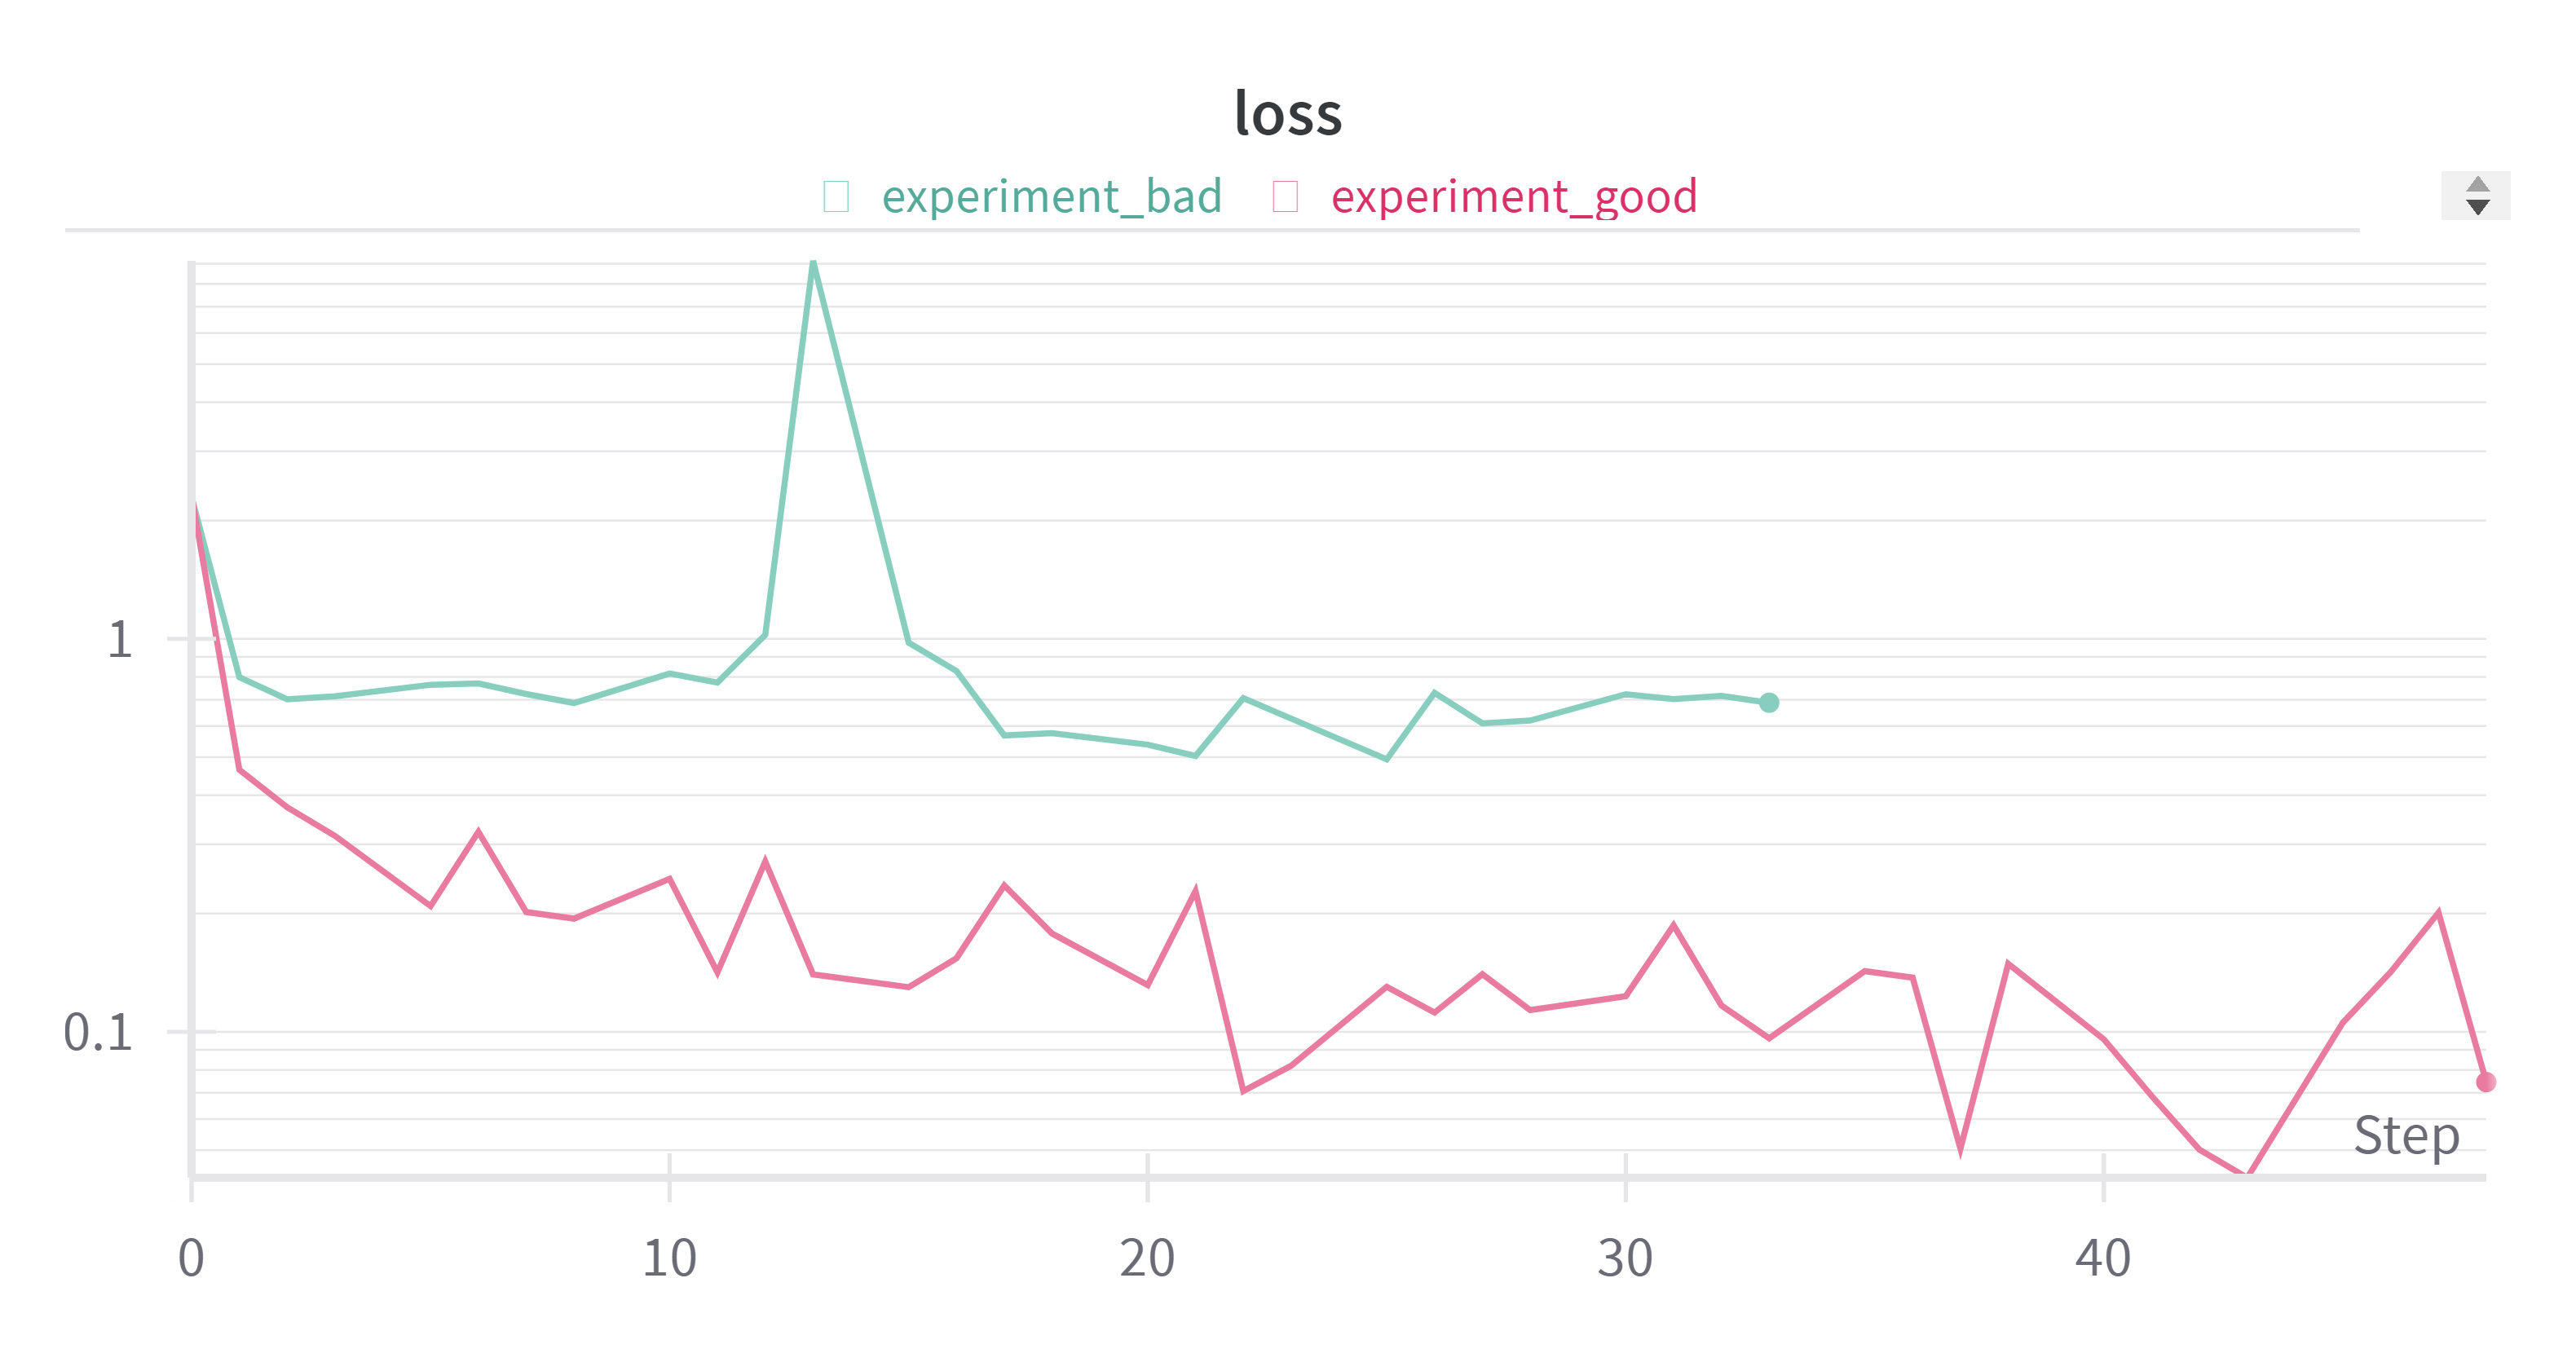